# 광도곡선 산출 코드

#### Dongho You KAIST ####
#### 2025.10.05. ####

이 노트북은 지상관측 데이터(FITS)를 입력으로 받아 전처리(바이어스/다크/플랫 보정) → 프레임 정렬 → 별 검출(DAOStarFinder) → 개구 포토메트리(annulus 배경 보정) → 비교성 선택 및 상대광도 계산(차분측광) → 이상치 제거·정규화 → 광도곡선 시각화/저장 → CSV 내보내기까지의 트랜싯 광도곡선 파이프라인을 end-to-end 로 수행합니다. 코드 내에는 JD/MJD 등 관측 시각 처리 루틴, 출력 디렉터리 생성, 결과물(플롯/CSV) 저장 코드가 포함되어 있습니다.

In [24]:
# ====== 기본 임포트 및 전역 설정 ======
import os, glob, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.time import Time
from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus

import astroalign as aa

# 경고 과다 출력 방지
warnings.filterwarnings("ignore", category=UserWarning)

# matplotlib 한글 폰트/유니코드 마이너스 대응(환경에 따라 필요시)
plt.rcParams['axes.unicode_minus'] = False

print("Imports OK")


Imports OK


In [25]:
# ====== 사용자 파라미터 ======
LIGHT_DIR   = "./WASP-12b data/object"   # 관측(light) 프레임 폴더
BIAS_DIR    = "./WASP-12b data/bias"     # 바이어스 폴더 (없으면 None 또는 빈 폴더)
DARK_DIR    = "./WASP-12b data/dark"     # 다크 폴더
FLAT_DIR    = "./WASP-12b data/flat"     # 플랫 폴더
OUTPUT_DIR  = "./WASP-12b_Basic_out5"      # 결과 저장 폴더

USE_BIAS = True
USE_DARK = True
USE_FLAT = True

# 정렬/저장 옵션
DO_ALIGNMENT        = True
SAVE_ALIGNED_FITS   = True
ALIGNED_DIR         = os.path.join(OUTPUT_DIR, "aligned_fits")

# 결과 플롯/CSV 경로
PLOT_DIR            = os.path.join(OUTPUT_DIR, "plots_allstars_lc")
SAVE_WIDE_CSV       = True
WIDE_CSV_PATH       = os.path.join(OUTPUT_DIR, "allstars_relflux_wide.csv")
TIME_CSV_PATH       = os.path.join(OUTPUT_DIR, "times_jd.csv")

# 검출/광도측정 파라미터
FWHM_PIX           = 3.5
THRESH_SIGMA       = 5.0
MAX_STARS_DETECT   = 2000
EDGE_MARGIN        = 12
R_AP               = 3.0 * FWHM_PIX
R_IN, R_OUT        = 6.0 * FWHM_PIX, 10.0 * FWHM_PIX
K_COMPS            = 3
BRIGHT_TOL_FRAC    = 0.30
MIN_SEP_PIX        = 3.0 * FWHM_PIX
CLIP_SIGMA         = 4.0

# 미리보기(검출표시) 설정
N_LABELS_PREVIEW   = 100   # 밝은 순서 최대 N개 라벨
PREVIEW_PATH       = os.path.join(OUTPUT_DIR, "detected_stars_preview.png")

# ====== 폴더 준비 ======
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
if SAVE_ALIGNED_FITS:
    os.makedirs(ALIGNED_DIR, exist_ok=True)

print("Paths ready.")


Paths ready.


In [26]:
# ====== 파일 검색 ======
def list_fits_in(dirpath):
    if not os.path.isdir(dirpath):
        return []
    files = sorted(glob.glob(os.path.join(dirpath, "*.fits")) + 
                   glob.glob(os.path.join(dirpath, "*.fit")))
    return files

# ====== 헤더에서 시간(JD/BJD/HJD/MJD/DATE-OBS) 읽기 ======
def read_time_from_header(hdr):
    # (1) JD/BJD/HJD
    for key in ["JD", "BJD", "HJD"]:
        if key in hdr:
            try:
                val = float(hdr[key])
                if np.isfinite(val):
                    return val
            except Exception:
                pass
    # (2) MJD
    if "MJD" in hdr:
        try:
            val = float(hdr["MJD"])
            if np.isfinite(val):
                return val + 2400000.5  # MJD -> JD
        except Exception:
            pass
    # (3) DATE-OBS (ISO 혹은 일반)
    if "DATE-OBS" in hdr:
        for fmt in ["isot", None]:
            try:
                if fmt == "isot":
                    return Time(hdr["DATE-OBS"], format="isot", scale="utc").jd
                else:
                    return Time(hdr["DATE-OBS"], scale="utc").jd
            except Exception:
                continue
    return np.nan

# ====== FITS 로딩 ======
def load_fits_data(path):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(float)
        hdr  = hdul[0].header
    return data, hdr

# ====== 다중 프레임 중앙값 결합 ======
def median_combine(files):
    if not files:
        return None, None
    stack = []
    hdr0 = None
    for p in files:
        dat, hdr = load_fits_data(p)
        if hdr0 is None:
            hdr0 = hdr
        stack.append(dat.astype(float))
    master = np.nanmedian(np.stack(stack, axis=0), axis=0)
    return master, hdr0

# ====== 마스터 바이어스 ======
def build_master_bias(bias_dir):
    files = list_fits_in(bias_dir)
    if not files:
        return None
    mbias, _ = median_combine(files)
    return mbias

# ====== 노출시간 추출 ======
def extract_exptime(hdr):
    for key in ["EXPTIME", "EXPOSURE", "EXP_TIME"]:
        if key in hdr:
            try:
                val = float(hdr[key])
                if np.isfinite(val):
                    return val
            except Exception:
                pass
    return None

# ====== 마스터 다크(노출시간별) ======
def build_master_dark_by_exptime(dark_dir):
    files = list_fits_in(dark_dir)
    if not files:
        return {}
    by_exp = {}
    for p in files:
        _, hdr = load_fits_data(p)
        expt = extract_exptime(hdr)
        if expt is None:
            continue
        by_exp.setdefault(expt, []).append(p)
    out = {}
    for expt, flist in by_exp.items():
        mdark, _ = median_combine(flist)
        out[expt] = mdark
    return out

# ====== 마스터 플랫(바이어스/다크 보정 후 정규화) ======
def build_master_flat(flat_dir, master_bias=None, dark_dict=None):
    files = list_fits_in(flat_dir)
    if not files:
        return None
    cal_stack = []
    for p in files:
        dat, hdr = load_fits_data(p)
        if master_bias is not None:
            dat = dat - master_bias
        if dark_dict is not None and len(dark_dict) > 0:
            expt = extract_exptime(hdr)
            if expt is not None:
                nearest = min(dark_dict.keys(), key=lambda k: abs(k - expt))
                scale = expt / nearest if nearest and nearest != 0 else 1.0
                dat = dat - dark_dict[nearest] * scale
        cal_stack.append(dat)
    mflat = np.nanmedian(np.stack(cal_stack, axis=0), axis=0)
    # 중앙값으로 정규화
    finite = np.isfinite(mflat)
    med = np.nanmedian(mflat[finite]) if np.any(finite) else None
    if med and np.isfinite(med) and med != 0:
        mflat = mflat / med
    return mflat

# ====== 프레임 보정(바이어스/다크/플랫) ======
def calibrate_frame(data, hdr, master_bias=None, dark_dict=None, flat_norm=None):
    out = data.astype(float).copy()
    if master_bias is not None:
        out = out - master_bias
    if dark_dict is not None and len(dark_dict) > 0:
        expt = extract_exptime(hdr)
        if expt is not None:
            nearest = min(dark_dict.keys(), key=lambda k: abs(k - expt))
            scale = expt / nearest if nearest and nearest != 0 else 1.0
            out = out - dark_dict[nearest] * scale
    if flat_norm is not None:
        with np.errstate(divide="ignore", invalid="ignore"):
            out = out / flat_norm
    return out

# ====== 정렬(astroalign) ======
def align_to_reference(src_img, ref_img):
    try:
        aligned, tf = aa.register(src_img, ref_img, detection_sigma=3.0, max_control_points=50)
        return aligned.astype(float), tf
    except aa.MaxIterError as e:
        raise RuntimeError(f"Alignment failed (MaxIterError): {e}")
    except Exception as e:
        raise RuntimeError(f"Alignment failed: {e}")

# ====== 별 검출(DAOStarFinder) ======
def detect_stars(ref_img):
    mean, med, std = sigma_clipped_stats(ref_img, sigma=3.0, maxiters=5)
    dao = DAOStarFinder(fwhm=FWHM_PIX, threshold=THRESH_SIGMA * std)
    tbl = dao(ref_img - med)
    if tbl is None or len(tbl) == 0:
        raise RuntimeError("No stars detected. Adjust FWHM/THRESH_SIGMA/FWHM_PIX.")
    # 밝은 순 정렬
    tbl.sort("flux")
    tbl = tbl[::-1]
    if len(tbl) > MAX_STARS_DETECT:
        tbl = tbl[:MAX_STARS_DETECT]
    xyf = np.vstack([tbl["xcentroid"].data, tbl["ycentroid"].data, tbl["flux"].data]).T
    H, W = ref_img.shape
    m = (xyf[:,0] > EDGE_MARGIN) & (xyf[:,0] < W-EDGE_MARGIN) & (xyf[:,1] > EDGE_MARGIN) & (xyf[:,1] < H-EDGE_MARGIN)
    return xyf[m]

# ====== 원형 aperture/annulus를 이용한 배경차감 순수 플럭스 ======
def measure_frame_photometry(img, xy):
    apert = CircularAperture(xy, r=R_AP)
    ann   = CircularAnnulus(xy, r_in=R_IN, r_out=R_OUT)
    ap_masks  = apert.to_mask(method="exact")
    ann_masks = ann.to_mask(method="exact")

    # (1) 배경(annulus) 중앙값
    sky_vals = []
    for m in ann_masks:
        ann_data = m.multiply(img)
        mask = (ann_data == 0) | ~np.isfinite(ann_data)
        sky_vals.append(np.nanmedian(ann_data[~mask]) if np.any(~mask) else 0.0)
    sky_vals = np.array(sky_vals, dtype=float)

    # (2) aperture 총합 - (배경 * 면적)
    fluxes = []
    for (m, sky) in zip(ap_masks, sky_vals):
        ap_data = m.multiply(img)
        mask = (ap_data == 0) | ~np.isfinite(ap_data)
        pix = ap_data[~mask]
        area = np.sum(~mask)
        if area == 0:
            fluxes.append(np.nan)
        else:
            fluxes.append(np.nansum(pix) - sky * area)
    return np.array(fluxes, dtype=float)

# ====== 비교성 선택(밝기 유사 & 최소 거리) ======
def pick_comps_for_target(target_idx, med_flux, xy, k=K_COMPS):
    tflux = med_flux[target_idx]
    tx, ty = xy[target_idx, 0], xy[target_idx, 1]
    lower, upper = (1.0 - BRIGHT_TOL_FRAC) * tflux, (1.0 + BRIGHT_TOL_FRAC) * tflux
    cand = []
    for j in range(len(med_flux)):
        if j == target_idx:
            continue
        if not np.isfinite(med_flux[j]):
            continue
        if (med_flux[j] >= lower) and (med_flux[j] <= upper):
            dx = xy[j,0] - tx
            dy = xy[j,1] - ty
            if math.hypot(dx, dy) >= MIN_SEP_PIX:
                cand.append((j, abs(med_flux[j] - tflux)))
    cand.sort(key=lambda t: t[1])
    return [c[0] for c in cand[:k]]

# ====== 강건한 상대광도(엔상블/시그마클리핑) ======
def robust_rel_flux(target_series, comps_series):
    denom = np.nansum(comps_series, axis=1)  # 비교성 합
    rel = target_series / denom              # 상대값
    med = np.nanmedian(rel)                  # 중앙값 정규화
    reln = rel / med if np.isfinite(med) and med != 0 else rel
    mu, sig = np.nanmedian(reln), np.nanstd(reln)
    ok = np.abs(reln - mu) < CLIP_SIGMA * sig if np.isfinite(sig) and sig > 0 else np.isfinite(reln)
    return reln, ok

# ====== 미리보기용 스트레치 ======
def _stretch(img, p_lo=1, p_hi=99):
    finite = np.isfinite(img)
    if not np.any(finite):
        return img
    v1, v2 = np.percentile(img[finite], [p_lo, p_hi])
    v1, v2 = float(v1), float(v2)
    out = np.clip((img - v1) / max(v2 - v1, 1e-9), 0, 1)
    return out

# ====== 검출 미리보기 저장(반지 & 라벨) ======
def save_detection_preview(ref_img, xy, path=PREVIEW_PATH, n_labels=N_LABELS_PREVIEW):
    disp = _stretch(ref_img)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(disp, cmap="gray", origin="lower")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("stretched intensity")

    # 앞쪽 n개만 도식화(라벨 난잡 방지)
    n = min(n_labels, xy.shape[0])
    apert = CircularAperture(xy[:n], r=R_AP)
    ann   = CircularAnnulus(xy[:n], r_in=R_IN, r_out=R_OUT)
    try:
        apert.plot(ax=ax, lw=1.2, color="cyan")
        ann.plot(ax=ax, lw=1.0, color="lime")
    except Exception:
        apert.plot(ax=ax, lw=1.2, color="cyan")

    # 라벨(스타 인덱스)
    for i in range(n):
        x, y = xy[i]
        ax.text(x+5, y+5, f"{i}", color="yellow", fontsize=9, weight="bold", ha="left", va="bottom")

    ax.set_title(f"Detected stars (N={xy.shape[0]}), aperture/annulus rings")
    ax.set_xlim(0, ref_img.shape[1])
    ax.set_ylim(0, ref_img.shape[0])
    plt.tight_layout()
    plt.savefig(path, dpi=160)
    plt.close()
    return path

# ====== 상대광도 플로팅(클리핑점 X마커) ======
def plot_lightcurve(times, rel_flux, ok_mask, title, outpath, comps_ids=None):
    t0 = np.nanmin(times)
    xh = (times - t0) * 24.0  # 시간(시간 단위)
    plt.figure(figsize=(7.2, 4.2))
    plt.scatter(xh[~ok_mask], rel_flux[~ok_mask], s=14, marker='x', alpha=0.6, label="clipped")
    plt.plot(xh[ok_mask], rel_flux[ok_mask], 'o', ms=3, label="data")
    plt.xlabel("Time since first frame [hr]")
    plt.ylabel("Relative flux (ensemble norm.)")
    if comps_ids is not None:
        sub = f" / comps: {','.join(map(str, comps_ids))}"
    else:
        sub = ""
    plt.title(f"{title}{sub}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(outpath, dpi=180)
    plt.close()

print("Utility functions ready.")


Utility functions ready.


In [27]:
# === Cell 3B: detrending & ensemble helpers (flux_mat 없어도 동작) ===
from numpy.linalg import lstsq

def pick_comps_rms_aware_general(ti, series_mat, bright_vec, xy, bright_tol=0.25, k=20):
    assert series_mat.ndim == 2
    assert bright_vec.ndim == 1 and series_mat.shape[1] == bright_vec.shape[0] == xy.shape[0]
    tflux = bright_vec[ti]
    lo, hi = (1.0 - bright_tol)*tflux, (1.0 + bright_tol)*tflux
    cand = [j for j in range(series_mat.shape[1])
            if j != ti and np.isfinite(bright_vec[j]) and lo <= bright_vec[j] <= hi]
    if not cand:
        return []
    rms_list = []
    for j in cand:
        s = series_mat[:, j]
        med = np.nanmedian(s)
        if not (np.isfinite(med) and med != 0):
            continue
        s_norm = s / med
        rms = np.nanstd(s_norm)
        rms_list.append((j, rms))
    if not rms_list:
        return []
    rms_list.sort(key=lambda t: t[1])
    return [j for j,_ in rms_list[:k]]

def weighted_reference(series_mat_comps):
    norm = series_mat_comps / np.nanmedian(series_mat_comps, axis=0)
    var  = np.nanvar(norm, axis=0)
    w = 1.0 / np.clip(var, 1e-8, None)
    w /= np.nansum(w)
    ref = np.nansum(series_mat_comps * w, axis=1)
    ref /= np.nanmedian(ref)
    return ref, w

def detrend_by_covariates(y, covs, max_iter=3, clip=3.0):
    X = np.column_stack([np.ones_like(y)] + [c for c in covs])
    good = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
    beta = np.zeros(X.shape[1])
    for _ in range(max_iter):
        beta, *_ = lstsq(X[good], y[good], rcond=None)
        model = X @ beta
        resid = y - model
        s = np.nanstd(resid[good])
        if not (np.isfinite(s) and s > 0):
            break
        good = good & (np.abs(resid) < clip*s)
    baseline = X @ beta
    corr = y / baseline
    corr /= np.nanmedian(corr[good])
    return baseline, corr, good


In [28]:
# ====== 라이트 프레임 로드 ======
light_files = list_fits_in(LIGHT_DIR)
if not light_files:
    raise FileNotFoundError(f"No light frames in {LIGHT_DIR}")
print(f"Found {len(light_files)} light frames.")

# ====== 마스터 프레임 생성 ======
mbias = build_master_bias(BIAS_DIR) if USE_BIAS else None
dark_dict = build_master_dark_by_exptime(DARK_DIR) if USE_DARK else {}
mflat = build_master_flat(FLAT_DIR, master_bias=mbias, dark_dict=dark_dict) if USE_FLAT else None

def brief_array(name, arr):
    """넘파이 배열을 요약해서 문자열로 반환."""
    if arr is None:
        return f"{name}: None"
    finite = np.isfinite(arr)
    if not np.any(finite):
        return f"{name}: shape={arr.shape}, all-NaN"
    med  = np.nanmedian(arr[finite])
    mean = np.nanmean(arr[finite])
    std  = np.nanstd(arr[finite])
    return f"{name}: shape={arr.shape}, med={med:.3f}, mean={mean:.3f}, std={std:.3f}"

def brief_dark_dict_summary(dark_dict):
    """노출시간별 마스터다크를 요약해서 여러 줄 문자열로 반환."""
    if not dark_dict:
        return "Master Dark(dict): None"
    lines = ["Master Dark(dict):"]
    for expt, mdark in sorted(dark_dict.items(), key=lambda kv: kv[0]):
        if mdark is None:
            lines.append(f"  - {expt:g}s: None")
            continue
        finite = np.isfinite(mdark)
        med  = np.nanmedian(mdark[finite]) if np.any(finite) else np.nan
        mean = np.nanmean(mdark[finite]) if np.any(finite) else np.nan
        std  = np.nanstd(mdark[finite])  if np.any(finite) else np.nan
        lines.append(
            f"  - {expt:g}s: shape={mdark.shape}, med={med:.3f}, mean={mean:.3f}, std={std:.3f}"
        )
    return "\n".join(lines)

print(brief_array("Master Bias", mbias))
print(brief_dark_dict_summary(dark_dict))      # ← 여기가 핵심 교정
print(brief_array("Master Flat(norm)", mflat))


Found 336 light frames.
Master Bias: shape=(1100, 1375), med=1279.500, mean=1279.198, std=4.825
Master Dark(dict):
  - 45s: shape=(1100, 1375), med=1286.500, mean=1286.949, std=69.627
Master Flat(norm): shape=(1100, 1375), med=1.000, mean=1.000, std=0.011


In [29]:
# ====== 기준 프레임(첫 라이트) 보정 ======
ref_raw, ref_hdr = load_fits_data(light_files[0])
ref_cal = calibrate_frame(ref_raw, ref_hdr, master_bias=mbias, dark_dict=dark_dict, flat_norm=mflat)
ref_img = ref_cal

# (선택) 보정 전/후 비교 이미지를 저장해두면 디버깅이 편리합니다.
before_path = os.path.join(OUTPUT_DIR, "preview_ref_before.png")
after_path  = os.path.join(OUTPUT_DIR, "preview_ref_after.png")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(_stretch(ref_raw), cmap="gray", origin="lower"); plt.title("Ref raw")
plt.subplot(1,2,2); plt.imshow(_stretch(ref_img), cmap="gray", origin="lower"); plt.title("Ref calibrated")
plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, "preview_ref_compare.png"), dpi=160); plt.close()

plt.imsave(before_path, _stretch(ref_raw), cmap="gray", origin="lower")
plt.imsave(after_path,  _stretch(ref_img), cmap="gray", origin="lower")

print("Saved:", before_path, "and", after_path)

# 기준 프레임을 정렬결과 폴더에 FITS로도 보관(아이덴티티 정렬)
if SAVE_ALIGNED_FITS:
    h = ref_hdr.copy()
    h["HISTORY"] = "calibrated; reference frame; aligned identity"
    fits.writeto(os.path.join(ALIGNED_DIR, os.path.basename(light_files[0])),
                 ref_img.astype(np.float32), h, overwrite=True)
    print("Reference FITS saved to aligned_fits.")


Saved: ./WASP-12b_Basic_out5\preview_ref_before.png and ./WASP-12b_Basic_out5\preview_ref_after.png
Reference FITS saved to aligned_fits.


In [30]:
xyf = detect_stars(ref_img)     # [x, y, flux]
xy  = xyf[:, :2]
print(f"Detected {len(xy)} stars on reference frame.")

prev_path = save_detection_preview(ref_img, xy, PREVIEW_PATH, N_LABELS_PREVIEW)
print(f"Detection preview saved:", prev_path)


Detected 72 stars on reference frame.
Detection preview saved: ./WASP-12b_Basic_out5\detected_stars_preview.png


In [31]:
from astropy.modeling.models import Gaussian2D

def get_header_airmass(hdr):
    # AIRMASS 또는 SECZ(=airmass 근사) 사용
    for k in ("AIRMASS", "SECZ"):
        if k in hdr:
            try:
                v = float(hdr[k])
                if np.isfinite(v) and v>0:
                    return v
            except Exception:
                pass
    return np.nan

def estimate_frame_fwhm(img, xy_ref, n=40, box=11):
    # 밝은 순 n개만 사용
    idx = np.arange(len(xy_ref))
    # ref_img 밝기 대신 현재 frame photometry가 있으면 그걸 쓰는게 더 좋지만,
    # 간단히 중심 근처 n개 사용
    use = idx[:min(n, len(idx))]
    sigmas = []
    h, w = img.shape
    r = box//2
    for i in use:
        x0, y0 = xy_ref[i]
        xi, yi = int(round(x0)), int(round(y0))
        if xi-r<0 or yi-r<0 or xi+r>=w or yi+r>=h: 
            continue
        cut = img[yi-r:yi+r+1, xi-r:xi+r+1]
        if not np.all(np.isfinite(cut)):
            continue
        # 2차 모멘트 기반 σ 추정
        yy, xx = np.mgrid[0:cut.shape[0], 0:cut.shape[1]]
        xbar = (cut*xx).sum()/cut.sum()
        ybar = (cut*yy).sum()/cut.sum()
        varx = (cut*((xx-xbar)**2)).sum()/cut.sum()
        vary = (cut*((yy-ybar)**2)).sum()/cut.sum()
        if varx>0 and vary>0:
            sigma = np.sqrt(0.5*(varx+vary))
            sigmas.append(float(sigma))
    if not sigmas:
        return np.nan
    sigma_pix = np.median(sigmas)
    return 2.3548 * sigma_pix  # FWHM = 2.3548 σ

airmass_list = []
fwhm_list    = []
sky_list     = []

for idx, p in enumerate(light_files):
    _, hdr = load_fits_data(p)              # 헤더만 재활용
    airmass_list.append(get_header_airmass(hdr))

# 정렬된 프레임(또는 보정된 프레임)을 다시 열어 FWHM/sky 계산
# 저장된 aligned_fits가 있으면 그걸 쓰는게 가장 정확
aligned_paths = sorted(glob.glob(os.path.join(ALIGNED_DIR, "*.fit*"))) if SAVE_ALIGNED_FITS else []
if aligned_paths and len(aligned_paths)==len(light_files):
    to_iter = aligned_paths
    open_data = lambda path: fits.getdata(path).astype(float)
else:
    # 정렬본이 없으면 다시 한 번 보정해서 추정(느릴 수 있음)
    to_iter = light_files
    open_data = lambda path: calibrate_frame(load_fits_data(path)[0], load_fits_data(path)[1],
                                             master_bias=mbias, dark_dict=dark_dict, flat_norm=mflat)

for path in to_iter:
    img = open_data(path)
    fwhm_list.append(estimate_frame_fwhm(img, xy, n=50, box=11))
    # 전역 하늘 밝기(중앙값) – 프레임마다 배경 변화 추적
    finite = np.isfinite(img)
    sky_list.append(np.nanmedian(img[finite]) if np.any(finite) else np.nan)

airmass_arr = np.array(airmass_list, dtype=float)
fwhm_arr    = np.array(fwhm_list,    dtype=float)
sky_arr     = np.array(sky_list,     dtype=float)

print("Covariates ready:",
      f"\n  Airmass:  n={np.sum(np.isfinite(airmass_arr))}/{len(airmass_arr)}",
      f"\n  FWHM(px): n={np.sum(np.isfinite(fwhm_arr))}/{len(fwhm_arr)}  median={np.nanmedian(fwhm_arr):.2f}",
      f"\n  Sky:      n={np.sum(np.isfinite(sky_arr))}/{len(sky_arr)}  median={np.nanmedian(sky_arr):.2f}")


Covariates ready: 
  Airmass:  n=336/336 
  FWHM(px): n=336/336  median=8.03 
  Sky:      n=336/336  median=-1093.05


In [32]:
# === Cell 8B: extract covariates (airmass, FWHM, sky) ===
def get_header_airmass(h):
    for k in ("AIRMASS","SECZ"):
        if k in h:
            try:
                v = float(h[k]); 
                if np.isfinite(v) and v>0: return v
            except: pass
    return np.nan

def estimate_frame_fwhm(img, xy_ref, n=50, box=11):
    idx = np.arange(len(xy_ref))
    use = idx[:min(n, len(idx))]
    h, w = img.shape; r = box//2; sigmas = []
    yy, xx = np.mgrid[0:box, 0:box]
    for i in use:
        x0, y0 = xy_ref[i]; xi, yi = int(round(x0)), int(round(y0))
        if xi-r<0 or yi-r<0 or xi+r>=w or yi+r>=h: continue
        cut = img[yi-r:yi+r+1, xi-r:xi+r+1]
        if not np.all(np.isfinite(cut)): continue
        s = cut.sum(); 
        if s<=0: continue
        xbar = (cut*xx).sum()/s; ybar = (cut*yy).sum()/s
        varx = (cut*((xx-xbar)**2)).sum()/s; vary = (cut*((yy-ybar)**2)).sum()/s
        if varx>0 and vary>0:
            sigmas.append(float(np.sqrt(0.5*(varx+vary))))
    if not sigmas: return np.nan
    return 2.3548*np.median(sigmas)

airmass_list, fwhm_list, sky_list = [], [], []

# airmass from headers of original light files
for p in list_fits_in(LIGHT_DIR):
    _, hdr = load_fits_data(p)
    airmass_list.append(get_header_airmass(hdr))

# choose image source
img_paths = sorted(glob.glob(os.path.join(ALIGNED_DIR, "*.fit*"))) if (SAVE_ALIGNED_FITS and os.path.isdir(ALIGNED_DIR)) else list_fits_in(LIGHT_DIR)
def _open_img(path):
    if SAVE_ALIGNED_FITS and os.path.dirname(path).endswith(os.path.basename(ALIGNED_DIR)):
        return fits.getdata(path).astype(float)
    dat, hdr = load_fits_data(path)
    return dat.astype(float)

for p in img_paths:
    img = _open_img(p)
    fwhm_list.append(estimate_frame_fwhm(img, xy, n=50, box=11))
    finite = np.isfinite(img); sky_list.append(np.nanmedian(img[finite]) if np.any(finite) else np.nan)

airmass_arr = np.array(airmass_list, float)
fwhm_arr    = np.array(fwhm_list,    float)
sky_arr     = np.array(sky_list,     float)
print("covariates →",
      f"airmass n={np.sum(np.isfinite(airmass_arr))}",
      f"fwhm n={np.sum(np.isfinite(fwhm_arr))}, med={np.nanmedian(fwhm_arr):.2f}",
      f"sky n={np.sum(np.isfinite(sky_arr))}, med={np.nanmedian(sky_arr):.2f}")


covariates → airmass n=336 fwhm n=336, med=4.44 sky n=336, med=-1093.05


In [33]:
times = []
rows = []
skipped = 0

for idx, p in enumerate(light_files):
    data, hdr = load_fits_data(p)
    cal = calibrate_frame(data, hdr, master_bias=mbias, dark_dict=dark_dict, flat_norm=mflat)

    if DO_ALIGNMENT and idx > 0:
        try:
            aligned, tf = align_to_reference(cal, ref_img)
        except Exception as e:
            print(f"[WARN] Align failed at {os.path.basename(p)}: {e}")
            skipped += 1
            continue
    else:
        aligned = cal

    t_jd = read_time_from_header(hdr)
    if not np.isfinite(t_jd):
        t_jd = np.nan
    times.append(t_jd)

    fluxes = measure_frame_photometry(aligned, xy)  # 길이 = 검출된 별 수
    rows.append(fluxes)

    if SAVE_ALIGNED_FITS:
        h = hdr.copy()
        h["HISTORY"] = "calibrated & aligned"
        fits.writeto(os.path.join(ALIGNED_DIR, os.path.basename(p)),
                     aligned.astype(np.float32), h, overwrite=True)

    if (idx+1) % 10 == 0:
        print(f" processed {idx+1}/{len(light_files)} frames...")

if skipped > 0:
    print(f"Alignment skipped {skipped} frames due to errors.")

print("Loop done. Measured photometry on", len(rows), "frames.")


 processed 10/336 frames...
 processed 20/336 frames...
 processed 30/336 frames...
 processed 40/336 frames...
 processed 50/336 frames...
 processed 60/336 frames...
 processed 70/336 frames...
 processed 80/336 frames...
 processed 90/336 frames...
 processed 100/336 frames...
 processed 110/336 frames...
 processed 120/336 frames...
 processed 130/336 frames...
 processed 140/336 frames...
 processed 150/336 frames...
 processed 160/336 frames...
 processed 170/336 frames...
 processed 180/336 frames...
 processed 190/336 frames...
 processed 200/336 frames...
 processed 210/336 frames...
 processed 220/336 frames...
 processed 230/336 frames...
 processed 240/336 frames...
 processed 250/336 frames...
 processed 260/336 frames...
 processed 270/336 frames...
 processed 280/336 frames...
 processed 290/336 frames...
 processed 300/336 frames...
 processed 310/336 frames...
 processed 320/336 frames...
 processed 330/336 frames...
Loop done. Measured photometry on 336 frames.


In [34]:
# ====== 행렬화 ======
flux_mat = np.vstack(rows)           # (N_frames, N_stars)
times = np.array(times, dtype=float) # (N_frames,)

# ====== 시간 결측 시 대체 ======
if np.any(~np.isfinite(times)):
    # 헤더에 시간이 없을 경우 프레임 인덱스를 시간축으로 사용
    times = np.arange(len(times), dtype=float)

# ====== 품질 필터(유효 비율 50% 초과 별만 유지) ======
valid_ratio = np.mean(np.isfinite(flux_mat), axis=0)
keep = valid_ratio > 0.5
xy, flux_mat = xy[keep], flux_mat[:, keep]

print(f"Kept {xy.shape[0]} stars after quality mask (>{0.5*100:.0f}% valid).")


Kept 72 stars after quality mask (>50% valid).


In [35]:
# --- series_mat 준비: 사용 가능한 소스에서 자동 선택 ---
def build_series_and_brightness():
    # 1) 이미 메모리에 절대 플럭스가 있으면 제일 좋음
    if 'flux_mat' in globals():
        series_mat = flux_mat
        bright_vec = np.nanmedian(flux_mat, axis=0)  # 절대 플럭스 중앙값 = 밝기 수준
        return series_mat, bright_vec

    # 2) rows 리스트(프레임별 포토메트리)가 있으면 재구성
    if 'rows' in globals() and isinstance(rows, list) and len(rows) > 0:
        series_mat = np.vstack(rows)
        bright_vec = np.nanmedian(series_mat, axis=0)
        return series_mat, bright_vec

    # 3) Wide CSV가 저장돼 있다면 로드 (JD 컬럼 제외)
    try:
        import pandas as pd, os
        if 'WIDE_CSV_PATH' in globals() and os.path.isfile(WIDE_CSV_PATH):
            df = pd.read_csv(WIDE_CSV_PATH)
            cols = [c for c in df.columns if c.lower() != 'jd']
            series_mat = df[cols].to_numpy(dtype=float)
            # 상대광도 CSV라면 모든 별의 중앙값이 ~1이므로 밝기유사 판별이 무의미
            # → ref 프레임에서 한 번 포토메트리하여 밝기 벡터를 만들거나,
            #   없으면 series_mat 중앙값을 fallback으로 사용
            if 'ref_img' in globals() and 'xy' in globals():
                bright_vec = measure_frame_photometry(ref_img, xy)
            else:
                bright_vec = np.nanmedian(series_mat, axis=0)
            return series_mat, bright_vec
    except Exception as e:
        print("[WARN] Failed to load WIDE_CSV:", e)

    raise RuntimeError("series_mat 소스를 찾지 못했습니다. flux_mat/rows/WIDE_CSV 중 하나가 필요합니다.")

series_mat, bright_vec = build_series_and_brightness()

# 무결성 체크
assert series_mat.ndim == 2
assert 'xy' in globals()
assert series_mat.shape[1] == xy.shape[0], f"shape mismatch: series_mat={series_mat.shape}, stars={xy.shape[0]}"


In [36]:
# === Sync frame paths with the matrix you are using ===
import os, glob
from astropy.io import fits
import numpy as np

def ensure_frame_paths_for_series(n_frames):
    """
    series_mat/raw_rel과 '같은 순서, 같은 개수'의 프레임 경로 리스트를 확보한다.
    우선순위: FRAME_PATHS(이미 있음) > aligned_paths > LIGHT_DIR
    """
    global FRAME_PATHS
    if 'FRAME_PATHS' in globals() and len(FRAME_PATHS) == n_frames:
        return FRAME_PATHS
    if 'aligned_paths' in globals() and len(aligned_paths) >= n_frames:
        FRAME_PATHS = aligned_paths[:n_frames]
        return FRAME_PATHS
    files = list_fits_in(LIGHT_DIR)
    assert len(files) >= n_frames, "LIGHT_DIR에 프레임이 부족합니다."
    FRAME_PATHS = files[:n_frames]
    return FRAME_PATHS

# series_mat/raw_rel과 같은 프레임 수로 맞추기
N_frames = len(raw_rel) if 'raw_rel' in globals() else series_mat.shape[0]
FRAME_PATHS = ensure_frame_paths_for_series(N_frames)


In [37]:
# === Rebuild covariates & times exactly for FRAME_PATHS ===
def get_header_airmass(h):
    for k in ("AIRMASS","SECZ"):
        if k in h:
            try:
                v = float(h[k])
                if np.isfinite(v) and v > 0:
                    return v
            except:
                pass
    return np.nan

def estimate_frame_fwhm(img, xy_ref, n=50, box=11):
    # 간단한 2차 모멘트 기반 FWHM 추정 (px)
    idx = np.arange(len(xy_ref))
    use = idx[:min(n, len(idx))]
    h, w = img.shape; r = box//2; sigmas = []
    yy, xx = np.mgrid[0:box, 0:box]
    for i in use:
        x0, y0 = xy_ref[i]; xi, yi = int(round(x0)), int(round(y0))
        if xi-r<0 or yi-r<0 or xi+r>=w or yi+r>=h: 
            continue
        cut = img[yi-r:yi+r+1, xi-r:xi+r+1]
        if not np.all(np.isfinite(cut)):
            continue
        s = cut.sum()
        if s <= 0:
            continue
        xbar = (cut*xx).sum()/s; ybar = (cut*yy).sum()/s
        varx = (cut*((xx-xbar)**2)).sum()/s; vary = (cut*((yy-ybar)**2)).sum()/s
        if varx>0 and vary>0:
            sigmas.append(float(np.sqrt(0.5*(varx+vary))))
    if not sigmas:
        return np.nan
    return 2.3548*np.median(sigmas)

def open_img_and_hdr(path):
    # aligned_fits면 header도 같이 읽고, 아니면 원본에서 보정 전 이미지로 추정(속도 우선)
    try:
        data = fits.getdata(path).astype(float)
        hdr  = fits.getheader(path)
    except Exception:
        data, hdr = load_fits_data(path)
    return data, hdr

def build_covariates_from_paths(paths):
    airmass, fwhm, sky, tt = [], [], [], []
    for p in paths:
        img, hdr = open_img_and_hdr(p)
        airmass.append(get_header_airmass(hdr))
        fwhm.append(estimate_frame_fwhm(img, xy, n=50, box=11))
        finite = np.isfinite(img)
        sky.append(np.nanmedian(img[finite]) if np.any(finite) else np.nan)
        t = read_time_from_header(hdr)
        tt.append(t if np.isfinite(t) else np.nan)
    airmass_arr = np.array(airmass, float)
    fwhm_arr    = np.array(fwhm,    float)
    sky_arr     = np.array(sky,     float)
    times_arr   = np.array(tt,      float)
    if np.any(~np.isfinite(times_arr)):
        times_arr = np.arange(len(paths), dtype=float)  # 시간 없으면 인덱스로 대체
    return airmass_arr, fwhm_arr, sky_arr, times_arr

airmass_arr, fwhm_arr, sky_arr, times_synced = build_covariates_from_paths(FRAME_PATHS)

# times 길이도 맞추기 (있다면 교체)
if 'times' not in globals() or len(times) != len(times_synced):
    times = times_synced

# (디버깅 출력)
print("synced lengths:",
      "y/raw_rel" if 'raw_rel' in globals() else "series_mat", 
      len(raw_rel) if 'raw_rel' in globals() else series_mat.shape[0],
      "| airmass", len(airmass_arr), "| fwhm", len(fwhm_arr), "| sky", len(sky_arr), "| times", len(times))


synced lengths: y/raw_rel 336 | airmass 336 | fwhm 336 | sky 336 | times 336


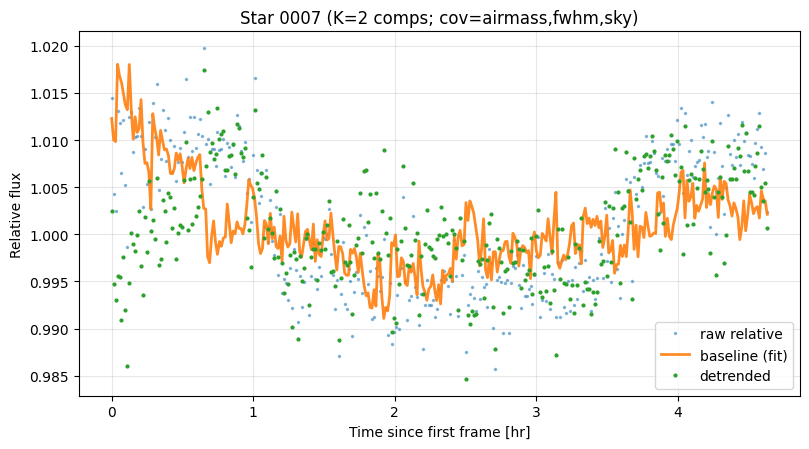

comp_ids: [8, 6] ... total 2


In [38]:
# === Cell 9B: choose series_mat automatically & analyze star 0053 ===
import pandas as pd, os

def build_series_and_brightness():
    # 1) 절대 플럭스 행렬이 메모리에 있으면 최상
    if 'flux_mat' in globals():
        return flux_mat, np.nanmedian(flux_mat, axis=0)
    # 2) rows 리스트로부터 복원
    if 'rows' in globals() and isinstance(rows, list) and len(rows) > 0:
        m = np.vstack(rows); return m, np.nanmedian(m, axis=0)
    # 3) wide CSV (상대광도일 수도 있음)
    if 'WIDE_CSV_PATH' in globals() and os.path.isfile(WIDE_CSV_PATH):
        df = pd.read_csv(WIDE_CSV_PATH)
        cols = [c for c in df.columns if c.lower() != 'jd']
        mat = df[cols].to_numpy(float)
        # 상대광도 CSV일 경우, ref 프레임에서 포토메트리로 밝기 벡터를 만드는 편이 낫다
        if 'ref_img' in globals() and 'xy' in globals():
            bv = measure_frame_photometry(ref_img, xy)
        else:
            bv = np.nanmedian(mat, axis=0)
        return mat, bv
    raise RuntimeError("series_mat source not found (need flux_mat OR rows OR WIDE_CSV_PATH).")

series_mat, bright_vec = build_series_and_brightness()
assert series_mat.shape[1] == xy.shape[0], f"shape mismatch: {series_mat.shape} vs stars={xy.shape[0]}"

# --- Star 0053 ---
TI, K = 7, 20
comp_ids = pick_comps_rms_aware_general(TI, series_mat, bright_vec, xy, bright_tol=0.25, k=K)
assert len(comp_ids) > 1, "비교성이 너무 적습니다. bright_tol↑ 혹은 K↑ 해보세요."

ref, w = weighted_reference(series_mat[:, comp_ids])
raw_rel = series_mat[:, TI] / ref
raw_rel /= np.nanmedian(raw_rel)

cov_list, cov_names = [], []
if 'airmass_arr' in globals() and np.any(np.isfinite(airmass_arr)): cov_list.append(airmass_arr); cov_names.append("airmass")
if 'fwhm_arr'    in globals() and np.any(np.isfinite(fwhm_arr)):    cov_list.append(fwhm_arr);    cov_names.append("fwhm")
if 'sky_arr'     in globals() and np.any(np.isfinite(sky_arr)):     cov_list.append(sky_arr);     cov_names.append("sky")

if cov_list:
    baseline, rel_corr, good = detrend_by_covariates(raw_rel, cov_list, max_iter=4, clip=3.0)
else:
    baseline = np.ones_like(raw_rel); rel_corr = raw_rel; good = np.isfinite(raw_rel)

t0 = np.nanmin(times) if 'times' in globals() else 0.0
xh = ((times - t0)*24.0) if 'times' in globals() else np.arange(len(raw_rel), float)

plt.figure(figsize=(8.2,4.6))
plt.plot(xh, raw_rel, '.', ms=3, alpha=0.45, label="raw relative")
if cov_list:
    plt.plot(xh, baseline/np.nanmedian(baseline), '-', lw=2, alpha=0.9, label="baseline (fit)")
plt.plot(xh, rel_corr, '.', ms=4, label="detrended")
plt.xlabel("Time since first frame [hr]" if 'times' in globals() else "Frame index")
plt.ylabel("Relative flux")
plt.title(f"Star {TI:04d} (K={len(comp_ids)} comps; cov={','.join(cov_names) if cov_names else 'none'})")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

print("comp_ids:", comp_ids[:12], f"... total {len(comp_ids)}")


In [39]:
# 0) 출력 폴더 준비 (덮어쓰기 싫으면 폴더명을 바꾸세요)
PLOT_DIR_DETREND = os.path.join(OUTPUT_DIR, "plots_allstars_lc_detrended")
os.makedirs(PLOT_DIR_DETREND, exist_ok=True)
CSV_DETREND_PATH = os.path.join(OUTPUT_DIR, "allstars_relflux_detrended_wide.csv")

# 1) 분석에 사용할 행렬(series_mat)과 밝기 벡터(bright_vec) 확보
#    (이미 위 셀에서 build_series_and_brightness()가 정의되어 있다고 가정)
series_mat, bright_vec = build_series_and_brightness()
assert series_mat.shape[1] == xy.shape[0], \
    f"shape mismatch: series_mat={series_mat.shape} vs stars={xy.shape[0]}"

N_frames, N_stars = series_mat.shape

# 2) 공변량 준비(있으면 사용). 길이 N_frames로 강제 동기화
cov_list, cov_names = [], []
def _sync_len(a):
    return a[:N_frames] if len(a) >= N_frames else np.pad(a, (0, N_frames-len(a)), constant_values=np.nan)

if 'airmass_arr' in globals() and np.any(np.isfinite(airmass_arr)):
    cov_list.append(_sync_len(np.asarray(airmass_arr, float))); cov_names.append("airmass")
if 'fwhm_arr' in globals() and np.any(np.isfinite(fwhm_arr)):
    cov_list.append(_sync_len(np.asarray(fwhm_arr, float)));    cov_names.append("fwhm")
if 'sky_arr' in globals() and np.any(np.isfinite(sky_arr)):
    cov_list.append(_sync_len(np.asarray(sky_arr, float)));     cov_names.append("sky")

# 3) 시간축 준비(있으면 시간→hours, 없으면 프레임 인덱스)
if 'times' in globals() and len(times) == N_frames:
    t0 = np.nanmin(times)
    xh = (times - t0) * 24.0
    x_label = "Time since first frame [hr]"
else:
    xh = np.arange(N_frames, dtype=float)
    x_label = "Frame index"

# 4) 보정 결과 누적(옵션: CSV 저장용)
rel_wide_det = {}
K = 20               # 비교성 개수(권장 15~25)
BRIGHT_TOL = 0.25    # 밝기 유사도 허용치(±25%)
MIN_COMPS  = 5       # 최소 비교성 수(부족하면 skip)

def plot_detrended_only(x, y, title, outpath):
    plt.figure(figsize=(7.6, 4.4))
    plt.plot(x, y, '.', ms=4)
    plt.xlabel(x_label)
    plt.ylabel("Relative flux (detrended)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outpath, dpi=180)
    plt.close()

saved = 0
skipped = 0

for ti in range(N_stars):
    # 4-1) 비교성 선택(밝기 유사 + 낮은 RMS)
    comp_ids = pick_comps_rms_aware_general(
        ti, series_mat, bright_vec, xy, bright_tol=BRIGHT_TOL, k=K
    )
    if len(comp_ids) < MIN_COMPS:
        skipped += 1
        continue

    # 4-2) 가중 참조곡선
    ref, _ = weighted_reference(series_mat[:, comp_ids])

    # 4-3) 상대광도 & 공변량 보정
    raw_rel = series_mat[:, ti] / ref
    raw_rel /= np.nanmedian(raw_rel)

    if cov_list:  # 공변량 있으면 detrend
        baseline, rel_corr, good = detrend_by_covariates(raw_rel, cov_list, max_iter=4, clip=3.0)
    else:
        rel_corr = raw_rel

    # 4-4) 저장(플롯 + CSV 누적)
    outpng = os.path.join(PLOT_DIR_DETREND, f"lc_star{ti:04d}_det.png")
    title  = f"Star {ti:04d} @ (x={xy[ti,0]:.1f}, y={xy[ti,1]:.1f})"
    plot_detrended_only(xh, rel_corr, title, outpng)

    rel_wide_det[f"star{ti:04d}"] = rel_corr
    saved += 1

    if saved % 25 == 0:
        print(f"  saved {saved} / processed {ti+1} stars...")

print(f"Done. Saved {saved} detrended PNGs to: {PLOT_DIR_DETREND} (skipped {skipped} stars)")

# 5) (옵션) detrended wide CSV 저장
if saved > 0:
    df = pd.DataFrame(rel_wide_det)
    # times가 있으면 함께 저장
    if 'times' in globals() and len(times) == N_frames:
        df.insert(0, "JD", times)
    df.to_csv(CSV_DETREND_PATH, index=False)
    print(f"Detrended wide CSV written: {CSV_DETREND_PATH}")


  saved 25 / processed 41 stars...
  saved 50 / processed 66 stars...
Done. Saved 56 detrended PNGs to: ./WASP-12b_Basic_out5\plots_allstars_lc_detrended (skipped 16 stars)
Detrended wide CSV written: ./WASP-12b_Basic_out5\allstars_relflux_detrended_wide.csv


In [40]:
# (선택) 생성된 라이트커브 일부를 미리 보기
from IPython.display import display, Image

sample_pngs = sorted(glob.glob(os.path.join(PLOT_DIR, "lc_star*.png")))[:5]
for p in sample_pngs:
    print(os.path.basename(p))
    display(Image(filename=p))
